In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

In [3]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1/7
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter 
gE    = 1/5
gA    = 1/3

tS    = 0.0            # rate S  -> Q
tE    = 0.01           # rate E  -> Q
tA    = 0.01           # rate A  -> Q
tIa   = 0.01           # rate Ia -> Q
tIs   = 1./3           # rate Is -> Q, three days for symptomatic people to be tested and quarantined 



# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
E0  = np.array([100, 100])
A0  = np.array([10, 10])
Ia0 = np.array([10, 10])     
Is0 = np.array([10, 10])     
Q0  = np.array([0, 0])
R0  = np.array([0, 0])     
S0  = Ni-(E0+A0+Ia0+Is0+R0+Q0)    


Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta,
              'gE':gE,'gA':gA,
              'gIa':gIa, 'gIs':gIs, 'fsa':fsa,
             'tS':tS,'tE':tE,'tA':tA,'tIa':tIa,'tIs':tIs, 
             'gAA': gA, 'gAS': gA} # legacy code 

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEAIRQ(parameters, M, Ni)
data = sto_model.simulate(S0, E0, A0, Ia0, Is0, Q0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('sto_traj.npy', data_array)

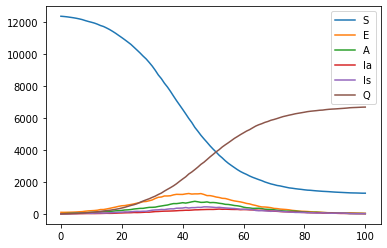

In [4]:
# plot the stochastic solution 
plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='E')
plt.plot(data_array[:, 2*M], label='A')
plt.plot(data_array[:, 3*M], label='Ia')
plt.plot(data_array[:, 4*M], label='Is')
plt.plot(data_array[:, 5*M], label='Q')

plt.legend()
plt.show()

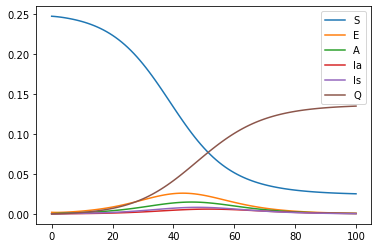

In [5]:
# load the data and rescale to intensive variables 
x = np.load('sto_traj.npy').astype('float')
x = x[:]/N
steps = 101 # number internal integration steps taken


# initialise the estimator 
estimator = pyross.inference.SEAIRQ(parameters, M, fi, int(N), steps)

det_model = pyross.deterministic.SEAIRQ(parameters, M, fi)
x_det = estimator.integrate(x[0], 0, Tf, Nf, det_model, contactMatrix)

plt.plot(x_det[:, 0], label='S')
plt.plot(x_det[:, M], label='E')
plt.plot(x_det[:, 2*M], label='A')
plt.plot(x_det[:, 3*M], label='Ia')
plt.plot(x_det[:, 4*M], label='Is')
plt.plot(x_det[:, 5*M], label='Q')
plt.legend()
plt.show()

In [6]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-2929.2404252029337
1.4992010593414307


In [8]:
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm, can use as a lower bound for parameters 

alpha_g = 0.2
alpha_bounds = (0.1, 0.5) # large uncertainty on the fraction of asymptomatic people 
# the upper bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.07
beta_bounds = (eps, 0.1) # large uncertainty on beta (e.g. during a lockdown, beta can be very low)

gIa_g = 0.2
gIa_bounds = (eps, 0.5) # large uncertainty on how quickly asymptomatic people recover 

gIs_g = 0.145
gIs_bounds = (0.13, 0.15) # tight bounds on gIs (can come from clinical data)

gE_g = 0.22
gE_bounds = (0.15, 0.25) # tight bounds on the exit rate from the exposed class 

gA_g = 0.3 
gA_bounds = (0.25, 0.35) # tight bounds on the exit rate from the activated class 

fsa_g = 0.8 # assume we know this precisely  

guess = [alpha_g, beta_g, gIa_g, gIs_g, gE_g, gA_g]
bounds = [alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds, gE_bounds, gA_bounds]

params, nit = estimator.inference(guess, x, Tf, Nf, contactMatrix, bounds, niter=1, ftol=1e-5, verbose=True)

basinhopping step 0: f -2931.8
basinhopping step 1: f -2934.01 trial_f -2934.01 accepted 1  lowest_f -2934.01
found new global minimum on step 1 with function value -2934.01


In [9]:
# compute log_p for best estimate 
print('best estimates: ', params)
print('nit: ', nit)

start_time = time.time() 
parameters = estimator.make_params_dict(params)
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

best estimates:  [0.19073604 0.02002299 0.13805519 0.14386272 0.20224162 0.33694637]
nit:  1
-2934.0105161150445
1.4642970561981201
